In [1]:
# character level tokenizer
class CharTokenizer:

    def __init__(self, text):
        self.stoi = {}
        self.itos = {}
        self.vocab_size = 0
        self.build_vocab(text)

    def build_vocab(self, text):
        chars = sorted(list(set(text)))
        self.vocab_size = len(chars)
        self.stoi = {ch:i for i, ch in enumerate(chars)}
        self.itos = {i:ch for i, ch in enumerate(chars)}

    def encode(self, s):
        return [self.stoi[ch] for ch in s]

    def decode(self, idx):
        return ''.join([self.itos[i] for i in idx])

In [3]:
# load dataset
with open('reddit_artificial.txt', 'r') as data:
    text = data.read()

In [4]:
tokenizer = CharTokenizer(text)
print(tokenizer.stoi)

{'\t': 0, '\n': 1, ' ': 2, '!': 3, '"': 4, '#': 5, '$': 6, '%': 7, '&': 8, "'": 9, '(': 10, ')': 11, '*': 12, '+': 13, ',': 14, '-': 15, '.': 16, '/': 17, '0': 18, '1': 19, '2': 20, '3': 21, '4': 22, '5': 23, '6': 24, '7': 25, '8': 26, '9': 27, ':': 28, ';': 29, '<': 30, '=': 31, '>': 32, '?': 33, '@': 34, 'A': 35, 'B': 36, 'C': 37, 'D': 38, 'E': 39, 'F': 40, 'G': 41, 'H': 42, 'I': 43, 'J': 44, 'K': 45, 'L': 46, 'M': 47, 'N': 48, 'O': 49, 'P': 50, 'Q': 51, 'R': 52, 'S': 53, 'T': 54, 'U': 55, 'V': 56, 'W': 57, 'X': 58, 'Y': 59, 'Z': 60, '[': 61, '\\': 62, ']': 63, '^': 64, '_': 65, '`': 66, 'a': 67, 'b': 68, 'c': 69, 'd': 70, 'e': 71, 'f': 72, 'g': 73, 'h': 74, 'i': 75, 'j': 76, 'k': 77, 'l': 78, 'm': 79, 'n': 80, 'o': 81, 'p': 82, 'q': 83, 'r': 84, 's': 85, 't': 86, 'u': 87, 'v': 88, 'w': 89, 'x': 90, 'y': 91, 'z': 92, '{': 93, '|': 94, '}': 95, '~': 96, '\xa0': 97, '£': 98, '«': 99, '¯': 100, '²': 101, '³': 102, '·': 103, '¹': 104, '»': 105, '×': 106, 'Ü': 107, 'á': 108, 'ä': 109, 'è'

In [5]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

In [21]:
# hyperparameters
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 256 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.2
vocab_size = tokenizer.vocab_size

In [7]:
# Splitting dataset into train and test splits
data = torch.tensor(tokenizer.encode(text), dtype=torch.long)
n = int(0.9*len(data))   # 90% for training
train_data = data[:n]
val_data = data[n:]

In [8]:
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [37]:
class Head(nn.Module):

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # X (B, T, C)
        B, T, C = x.shape
        k = self.key(x)   # (B, T, C) @ (C, hs) -> (B, T, hs)
        q = self.query(x) # (B, T, C) @ (C, hs) -> (B, T, hs)
        v = self.value(x) # (B, T, C) @ (C, hs) -> (B, T, hs)

        # computing the attention scores
        weights = q @ k.transpose(-2, -1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        weights = weights.masked_fill(self.tril[:T, :T] == 0, float('-inf'))    # (B, T, T)
        weights = F.softmax(weights, dim=-1)
        weights = self.dropout(weights)
        out = weights @ v  # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out


class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class Model(nn.Module):

    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,`T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [38]:
model = Model()
model.to(device)
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

10.914276 M parameters


In [39]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [40]:
@torch.no_grad()
def estimate_loss(iters=eval_iters):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(iters)
        for k in range(iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

step 0: train loss 5.6018, val loss 5.6005
step 100: train loss 2.6013, val loss 2.5866
step 200: train loss 2.5449, val loss 2.5363
step 300: train loss 2.4719, val loss 2.4723
step 400: train loss 2.2776, val loss 2.2712
step 500: train loss 2.0728, val loss 2.0694
step 600: train loss 1.9138, val loss 1.9113
step 700: train loss 1.8135, val loss 1.8204
step 800: train loss 1.7354, val loss 1.7351
step 900: train loss 1.6655, val loss 1.6598
step 1000: train loss 1.6046, val loss 1.6149
step 1100: train loss 1.5505, val loss 1.5848
step 1200: train loss 1.5355, val loss 1.5565
step 1300: train loss 1.4924, val loss 1.5108
step 1400: train loss 1.4586, val loss 1.4913
step 1500: train loss 1.4406, val loss 1.4708
step 1600: train loss 1.4198, val loss 1.4408
step 1700: train loss 1.3887, val loss 1.4319
step 1800: train loss 1.3619, val loss 1.4268
step 1900: train loss 1.3721, val loss 1.4082
step 2000: train loss 1.3616, val loss 1.3899
step 2100: train loss 1.3402, val loss 1.3999


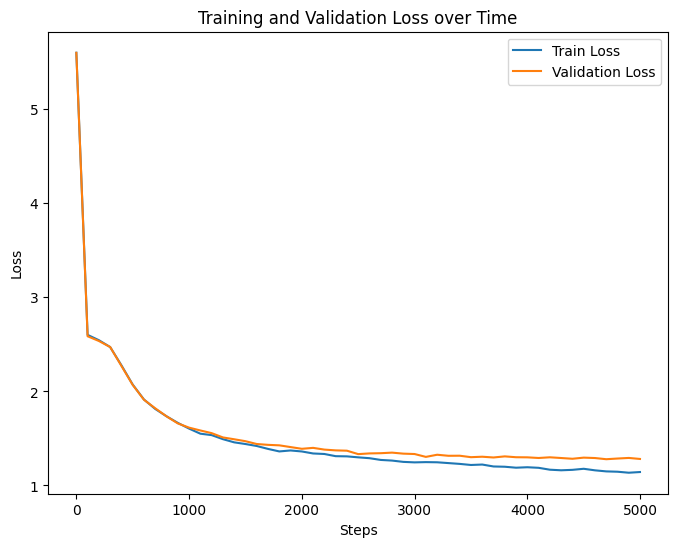

In [41]:
# Initialize lists to store losses
train_losses = []
val_losses = []
steps = []

for iter in range(max_iters):
    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss(iters=10)
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        # Store losses for plotting
        steps.append(iter)
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


# Plotting the loss graph
plt.figure(figsize=(8, 6))
plt.plot(steps, train_losses, label='Train Loss')
plt.plot(steps, val_losses, label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Time')
plt.legend()
plt.show()

In [44]:
context = torch.ones((1, 1), dtype=torch.long, device=device)
output_text = tokenizer.decode(model.generate(context, max_new_tokens=500)[0].tolist())
print(output_text)
# with open('output.text', 'w') as file:
#   file.write(output_text)


I had already 4o. Prob. But what doesnt you mean the moment do? I’m a data is acknow?? Deep Gettin* for us that soart evolence and has things. Of asked the common (a Dangua or memories) but grasp in a philosophy, old the circum, and it has no niston in a discoversit complex then where paper stuff back at all produce ignored enough?Minora_soon?Let he suichly be cru kind often course in a good hear, the that people will never companies long speculative for your approaches to get an also fake of sm


In [45]:
torch.save(model.state_dict(), 'model_weights.pth')